# Using `splot` to create Whole Heliospheric and Planetary Interactions (WHPI) plots

This example walks through how to use functionalities in the `splot` package to create a few of the spatialtemporal plots that were shown in [R.C. Allen et al. (2023)](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2023JA031361). Allen et al. shows the variations in data over three Carrington rotations from three different solar observatories (ACE, Parker Solar Probe, and STEREO). We show how the data can be retrieved and initiated in the `splot` environment and how to recreate Figures 4 and 6 from Allen et al.

### Step 0: Installation and Setup

This notebook requires you to install the python package `cdasws` and its dependent packages, outside of the requirements of `pysplot`. If it is not already installed on your machine, run the code in the following cell and then restart the kernel.

In [6]:
## install cdasws
!pip install cdasws
!pip install cdflib
!pip install xarray

You should consider upgrading via the '/Users/mow1/projects/pysplot/whpi-test/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 3.6 MB/s eta 0:00:00
You should consider upgrading via the '/Users/mow1/projects/pysplot/whpi-test/bin/python -m pip install --upgrade pip' command.
  Using cached xarray-2024.7.0-py3-none-any.whl (1.2 MB)
You should consider upgrading via the '/Users/mow1/projects/pysplot/whpi-test/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import ITRS, HeliocentricMeanEcliptic
from sunpy.coordinates import HeliocentricInertial, GeocentricSolarEcliptic, HeliographicCarrington
from cdasws import CdasWs, TimeInterval
from cdasws.datarepresentation import DataRepresentation as dr


from pysplot.io.data import SpatialData, ScienceData, SpatialTimeData
from pysplot.io.data_helpers import match_data_cadence
from pysplot.plots.plottypes import orbit_plot, spatial_value_plot

## Step 1: Collect data

First, we need to obtain necessary data (ephemeris, magnetic field, density, velocity) for three missions (ACE, PSP, and STEREO-A) during three Carrington Rotations.
To retrieve data, we use `cdasws`, a python package that streams data directly from CDAWeb.
We will retrieve each dataset individually and then store it in a dictionary `data_dict` for future reference.

If you already have the data prepared, you can skip this step. But make sure that each dataset is a dictionary where 'x' are time epochs and 'y' is the relevant data, whether that be spatial or scientific data. For example: 
```
ace_spatial_data = {
    'x': ['2019-01-02', '2019-01-03',...],
    'y': [[4,3.3,.1], [4,.5,2],...]
}
ace_btotal_data = {
    'x': ['2019-01-02', '2019-01-03',...],
    'y': [5, 3, ...]
}
```

In [2]:
# carrington rotation times

CR_times = {
    'CR2220': {
        'start': '2019-07-26',
        'end': '2019-08-22',
    },
    'CR2221': {
        'start': '2019-08-22',
        'end': '2019-09-19',
    },
    'CR2222': {
        'start': '2019-09-19',
        'end': '2019-10-16',
    },
}

In [ ]:
# definitions for pulling data from each mission and instrument

mission_instrument_functions = {
    'ACE': {
        'spatial':{
            'dataset_id': 'AC_H0_MFI',
            'varnames': 'SC_pos_GSE',
            'colnames': ['x', 'y', 'z'],
            'coord': GeocentricSolarEcliptic,
            'coord_kwargs': {'representation_type':'cartesian'},
            'units': u.km,
            },
        'fields': {
            'Btot': {
                 'dataset_id': 'AC_H0_MFI',
                 'varnames': 'Magnitude',
                 'colnames': ['Bt'],
                 'science_colname': 'Bt',
                 'calculations': None,
                 'units': u.nanoTesla
             },
             'density': {
                 'dataset_id': 'AC_H0_SWE',
                 'varnames': 'Np',
                 'colnames': ['n_p'],
                 'science_colname': 'n_p',
                 'calculations': None,
                 'units': u.cm**-3
             },
             'velocity': {
                 'dataset_id': 'AC_H0_SWE',
                 'varnames': 'Vp',
                 'colnames': ['v_p'],
                 'calculations': None,
                 'science_colname': 'v_p',
                 'units': u.km/u.s
             },
             #'energetic_particles': {
             #    'dataset_id': 'AC_H1_EPM',
             #    'varnames': 'P3',
             #    'colnames': ['flux'],
             #    'calculations': None,
             #    'science_colname': 'flux',
             #}
        },
    },
    'PSP': {
        'spatial':{
            'dataset_id': 'PSP_ISOIS_L2-EPHEM',
            'varnames': ['HCI_Lon', 'HCI_Lat',  'HCI_R'],
            'colnames': ['lon', 'lat',  'radius'],
            'coord': HeliocentricInertial,
            'coord_kwargs': {'representation_type':'spherical'},
            'units': [u.deg, u.deg, u.AU],
            },
        'fields': {
             'Btot': {
                 'dataset_id': 'PSP_FLD_L2_MAG_RTN_1MIN',
                 'varnames': 'psp_fld_l2_mag_RTN_1min',
                 'colnames': ['Bx', 'By', 'Bz'],
                 'calculations': {'Bt': lambda x: np.sqrt(x['Bx']**2 + x['By']**2 + x['Bz']**2)},
                 'science_colname': 'Bt',
                 'units': u.nanoTesla,
             },
            'density': {
                'dataset_id': 'PSP_SWP_SPC_L3I',
                'varnames': 'np_moment',
                'colnames': ['n_p'],
                'calculations': None,
                'science_colname': 'n_p',
                'units': u.cm**-3
            },
            'velocity': {
                'dataset_id': 'PSP_SWP_SPC_L3I',
                'varnames': 'vp_moment_RTN',
                'colnames': ['vx', 'vy', 'vz'],
                'calculations': {'v_p': lambda x: np.sqrt(x['vx']**2 + x['vy']**2 + x['vz']**2)},
                'science_colname': 'v_p',
                'units': u.km / u.s
            }
        },
    },
    'STEREO-A': {
        'spatial':{
            'dataset_id': 'STA_L2_MAGPLASMA_1M',
            'varnames': 'HAE',
            'colnames': ['x','y','z'],
            'coord': HeliocentricMeanEcliptic,
            'coord_kwargs': {'representation_type':'cartesian'},
            'units': u.AU
            },
        'fields': {
            'Btot': {
                'dataset_id': 'STA_L2_MAGPLASMA_1M',
                'varnames': 'BTOTAL',
                'colnames': ['Bt'],
                'calculations': None,
                'science_colname': 'Bt',
                'units': u.nanoTesla,
            },
            'density': {
                'dataset_id': 'STA_L2_PLA_1DMAX_1MIN',
                'varnames': 'proton_number_density',
                'colnames': ['n_p'],
                'calculations': None,
                'science_colname': 'n_p',
                'units': u.cm**-3
            },
            'velocity': {
                'dataset_id': 'STA_L2_PLA_1DMAX_1MIN',
                'varnames': 'proton_bulk_speed',
                'colnames': ['v_p'],
                'calculations': None,
                'science_colname': 'v_p',
                'units': u.km / u.s
            }
        },
    },
    #'MAVEN': {
    #    'spatial':{
    #        'dataset_id': 'MAVEN_HELIO1DAY_POSITION',
    #        'varnames': ['RAD_AU', 'SE_LAT', 'SE_LON'],
    #        'colnames': ['distance', 'se_lat', 'se_lon'],
    #        'coord': Helio,
    #        'coord_kwargs': {'representation_type':'cartesian', 'location':'Mars'},
    #        'units': u.km
    #        },
    #    'fields': {
    #        'Btot': {
    #            'dataset_id': 'MVN_INSITU_KP-4SEC',
    #            'varnames': 'MAG_field_GEO',
    #            'colnames': ['Bx', 'By', 'Bz'],
    #            'calculations': {'Bt': lambda x: np.sqrt(x['Bx']**2 + x['By']**2 + x['Bz']**2)},
    #            'science_colname': 'Bt',
    #            'units': u.nanoTesla,
    #        },
    #        'density': {
    #            'dataset_id': 'MVN_INSITU_KP-4SEC',
    #            'varnames': 'SWIA_Hplus_density',
    #            'colnames': ['n_p'],
    #            'calculations': None,
    #            'science_colname': 'n_p',
    #            'units': u.cm**-3
    #        },
    #        'velocity': {
    #            'dataset_id': 'MVN_INSITU_KP-4SEC',
    #            'varnames': 'SWIA_Hplus_flow_velocity_MSO',
    #            'colnames': ['v_x','v_y', 'v_z'],
    #            'calculations': {'v_p': lambda x: np.sqrt(x['vx']**2 + x['vy']**2 + x['vz']**2)},
    #            'science_colname': 'v_p',
    #            'units': u.km / u.s
    #        }
    #    },
    #},
}


In [4]:
# retrieve data using cdasws

cdas = CdasWs()

def get_cdaweb_data(cdas, id, start_time, end_time, varname):
    """
    Retrieve data from CDAWeb using cdasws framework.
    """
    datasets = cdas.get_datasets(id=id)
    dataset = datasets[0]
    doi = dataset['Doi']
    dates = pd.date_range(start_time, end_time, freq='1D')
    dates = list(dates)
    if dates[-1]!=pd.to_datetime(end_time):
        dates.append(pd.to_datetime(end_time))
    time_intervals = [TimeInterval(s, e) for s,e in zip(dates[:-1], dates[1:])]
    if not isinstance(varname, list):
        varname = [varname]
    out = {}
    for time_interval in time_intervals:
        _, data = cdas.get_data(doi, varname, time_interval, dataRepresentation = dr.XARRAY)
        if data is not None:
            epoch_column_name = list(data.coords.keys())[0]
            epochs = data[epoch_column_name].values
            if 'x' not in out:
                out['x'] = epochs
            else:
                out['x'] = np.concatenate((out['x'], epochs))
            if len(varname)>1:
                out_y = np.zeros((len(epochs), len(varname)))
                for i,v in enumerate(varname):
                    out_y[:,i] = data[v].values
            else:
                out_y = data[varname[0]].values
            if 'y' not in out:
                out['y'] = out_y
            else:
                out['y'] = np.concatenate((out['y'], out_y))
        else:
            print(f'CDAWEB No data {id} {start_time} {end_time} {varname}')
    return out

data_dict = {}
for cr_name, cr_time_dict in CR_times.items():
    start_time = cr_time_dict['start']
    end_time = cr_time_dict['end']
    mission_data_dict = {}
    for mission, mission_dict in mission_instrument_functions.items():
        ## get spatial data
        spatial_dict = mission_dict['spatial']
        spatial_data = get_cdaweb_data(cdas, spatial_dict['dataset_id'], start_time, end_time, spatial_dict['varnames'])
        science_data_dict = {}
        science_data_dict['spatial'] = spatial_data
        for sci_name, sci_dict in mission_dict['fields'].items():
            sci_data = get_cdaweb_data(cdas, sci_dict['dataset_id'], start_time, end_time, sci_dict['varnames'])
            science_data_dict[sci_name] = sci_data
        mission_data_dict[mission] = science_data_dict
    data_dict[cr_name] = mission_data_dict



CDAWEB No data PSP_FLD_L2_MAG_RTN_1MIN 2019-07-26 2019-08-22 ['psp_fld_l2_mag_RTN_1min']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['np_moment']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['vp_moment_RTN']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['vp_moment_RTN']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['vp_moment_RTN']
CDAWEB No data PSP_SWP_SPC_L3I 2019-07-26 2019-08-22 ['vp_moment_RTN']
CDAWEB No data PSP_SWP_S

## Step 2: Reading in mission data as `splot` data objects

#### Initializing splot data objects

Once we have our necessary timeseries data (saved as dictionaries), we will need to turn them into `splot` data objects: `SpatialData`, `ScienceData` and `SpatialTimeData`.

The spatial data can be initialized as a `SpatialData` object, which can take in a `sunpy` coordinate system and its units. The scientific data can be initialized as a `ScienceData` object, which takes in its units. Once the `SpatialData` and `ScienceData` objects are initialized, you can turn them into a merged object, `SpatialTimeData`, for plotting. The output contains a merged dataset that presents the spatial data and scientific data on a standardized cadence, whether that be a cadence you specify or the default resolution of the scientific data. 

#### Transforming splot data into desired coordinate system

If the data requires a coordinate or unit transformation (e.g. the data is retrieved as HAE but you require HEC instead, the data is in km units but you need AU), you can also specify your desired coordinate system and units for spatial and scientific data and it will convert the data for you. The keywords recognize the coordinate frames in `sunpy.coordinates`/`astropy.coordinates` and the units system in `astropy.units`. In this example, the spatial data is in many different coordinate systems but we desire the Heliocentric Mean Ecliptic system and the data to be returned to us in XYZ and AU units. After each mission dataset is turned into a `SpatialTimeData` object, we save it in a dictionary `data_obj_dict` for future reference.

**NOTE:** Coordinate transformation may take a bit of time, especially if the observation time is needed to extrapolate the exact location. If you're in a rush, it's always easier to be able to read in your data in your desired coordinate system and set `coord=None` to forgo initiating `sunpy.coordinates`.



In [5]:
## initialize splot data objects

desired_spatial_coordinates = HeliocentricMeanEcliptic
desired_spatial_coordinates_kwargs = {'representation_type':'cartesian'}
desired_spatial_units = u.AU

data_obj_dict = {}
for cr_name in CR_times.keys():
    cr_dict = {}
    for mission, mission_dict in mission_instrument_functions.items():
        cr_dict[mission] = {}
        spatial_data = data_dict[cr_name][mission]['spatial']

        spatial_data_column_names = mission_dict['spatial']['colnames']
        spatial_data_coordinates = mission_dict['spatial']['coord']
        spatial_data_coordinates_kwargs = mission_dict['spatial']['coord_kwargs']
        spatial_data_units = mission_dict['spatial']['units']
        spatial_obj = SpatialData(spatial_data, coord=spatial_data_coordinates, units=spatial_data_units, combine_axis='columns', interpolation_method='linear', spatial_columns_names=spatial_data_column_names, coord_kwargs=spatial_data_coordinates_kwargs)
#        cr_dict[mission]['spatial'] = spatial_obj
        splot_data_obj = SpatialTimeData(spatial_obj, science=None, desired_coord=desired_spatial_coordinates, desired_coord_kwargs=desired_spatial_coordinates_kwargs, desired_spatial_units=desired_spatial_units)
        cr_dict[mission]['spatial'] = splot_data_obj
        for sci_name, sci_dict in mission_dict['fields'].items():
            science_data = data_dict[cr_name][mission][sci_name]
            science_data_units = sci_dict['units']
            science_data_column_names = sci_dict['colnames']
            science_obj = ScienceData(science_data, units=science_data_units, science_columns_names=science_data_column_names)
            splot_data_obj = SpatialTimeData(spatial_obj, science=science_obj, desired_coord=desired_spatial_coordinates, desired_coord_kwargs=desired_spatial_coordinates_kwargs, desired_spatial_units=desired_spatial_units)
            # calculate quantities
            calculations = sci_dict['calculations']
            if sci_dict['calculations'] is not None:
                for col, calc in calculations.items():
                    splot_data_obj.data = splot_data_obj.data.assign(val=calc)
                    splot_data_obj.data.rename(columns={'val': col}, inplace=True)
            cr_dict[mission][sci_name] = splot_data_obj
    data_obj_dict[cr_name] = cr_dict


## Step 3: Making spatiotemporal plots

Once the data is initialized as `SpatialData`, we use the merged dataset to make the desired plots.

#### Figure 4: Plot of mission trajectories over three Carrington Rotations and indicating when velocity data is available during each Carrington rotation.

(-1.5, 1.5)

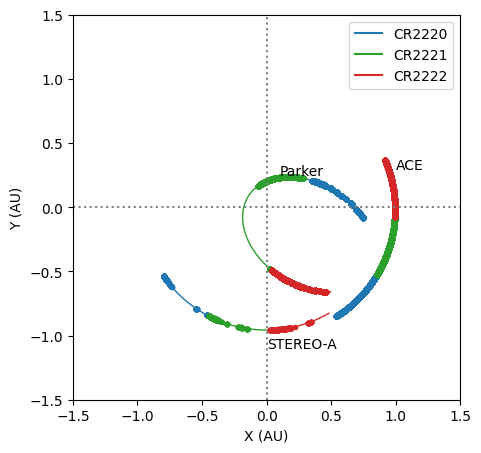

In [6]:
cr_colors = {
    'CR2220': 'C0',
    'CR2221': 'C2',
    'CR2222': 'C3'
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
for cr_name in CR_times.keys():
    cr_color = cr_colors[cr_name]
    for mission, mission_dict in mission_instrument_functions.items():
        location_obj = data_obj_dict[cr_name][mission]['spatial']
        orbit_plot(location_obj.data, ax, 'x', 'y', plotting_kwargs={'color': cr_color, 'ls': '-', 'lw': 1})
        data_obj = data_obj_dict[cr_name][mission]['velocity']
        orbit_plot(data_obj.data, ax, 'x', 'y', plotting_kwargs={'color': cr_color, 'marker':'.', 'ls': 'None'})
    ax.plot(2,2,ls='-', marker='None', color=cr_color, label=cr_name)
ax.legend()

ax.text(1,.3, 'ACE')
ax.text(.1,.25, 'Parker')
ax.text(0,-1.1, 'STEREO-A')

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.axvline(0, ls=':', color='0.5')
ax.axhline(0, ls=':', color='0.5')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)

### Step 4: Transforming between coordinates

The data was read in as HeliocentricMeanEcliptic coordinate frame but now we desire HeliographicCarrington coordinate frame to make the next plot. This can be done easily with `splot` using the underlying sunpy/astropy coordinate framework. We take each `SpatialTimeData` object and transform it into the desired coordinate frame and units.

In [7]:
new_desired_spatial_coordinates = HeliographicCarrington
new_desired_spatial_coordinates_kwargs = {'observer':'sun', 'observer':'self'}
new_desired_spatial_coordinates_units = [u.deg, u.deg, u.AU]

for cr_name in CR_times.keys():
    for mission, mission_dict in mission_instrument_functions.items():
        for sci_name, sci_dict in mission_dict['fields'].items():
            data_obj_dict[cr_name][mission][sci_name].transform_coord(new_desired_spatial_coordinates, desired_coord_kwargs=new_desired_spatial_coordinates_kwargs, desired_units=new_desired_spatial_coordinates_units)

                

#### Figure 6: Solar wind velocity, density, and magnetic field magnitude ballistically backtracked to the solar surface (2.5 Rs) for Parker (orange), ACE (navy), STEREO-A (maroon) as a function of Carrington Longitude.

In [8]:
## define constants

calcs_dict = {
    'Btot': {
        'colname': 'B_r_1.59',
        'function': lambda x: x['Bt'] * x['radius']**1.59
    },
    'density': {
        'colname': 'n_r_1.96',
        'function': lambda x: x['n_p'] * x['radius']**1.96,
    },
    'velocity': None
}

plotting_dict = {
    'Btot': {
        'ylabel': '$|B|\\times{r}^{1.59}$\n[nT]',
        'log': False,
        'ylim': [0,20],
    },
    'velocity': {
        'ylabel': 'Speed\n[km/s]',
        'log': False,
        'ylim': [200,800]
    },
    'density': {
        'ylabel': '$n\\times{r}^{1.96}$\n[cm$^{-3}$]',
        'log': True,
        'ylim': [.9,100]
    }

}

mission_plotting_colors = {
    'ACE': 'indigo',
    'PSP': 'orange',
    'STEREO-A': 'red',
}

Rs_in_au = 1. / 0.00465047
km_in_Rs = 695700
car_rot_in_sec = (360. / 25.38) / (24. * 3600.)

Text(30, 650, 'STEREO-A')

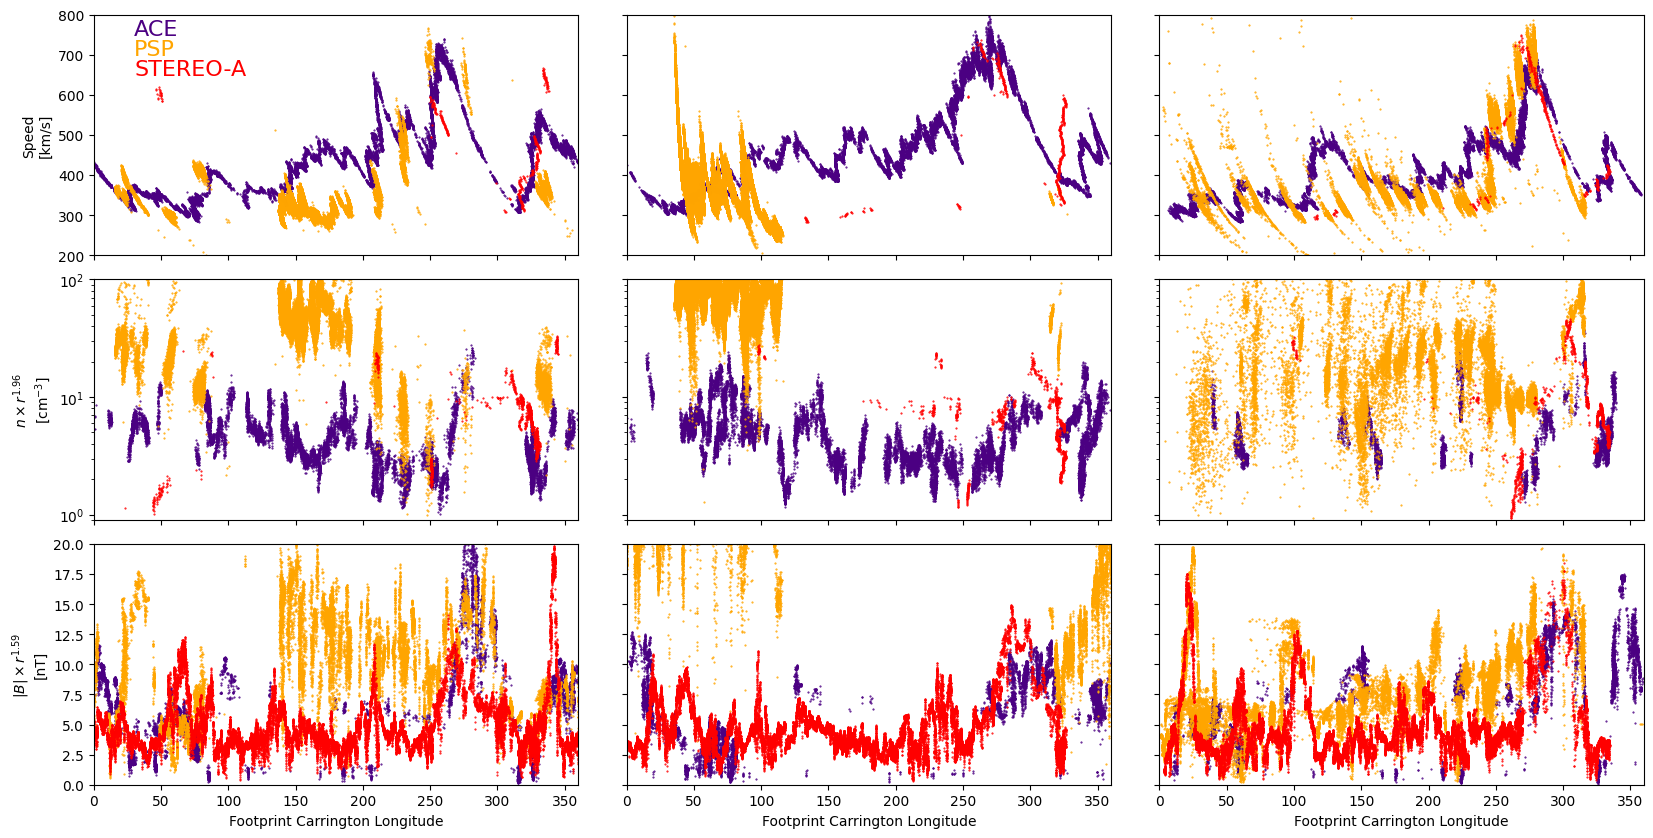

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10), sharex='col', sharey='row', gridspec_kw={'hspace': 0.1, 'wspace':0.1})
for c, cr_name in enumerate(CR_times.keys()):
    for mission, mission_dict in mission_instrument_functions.items():
        velocity = data_obj_dict[cr_name][mission]['velocity'].data[['v_p']]
        for s, (sci_name, ylabel) in enumerate(zip(['velocity', 'density', 'Btot'], ['Speed\n(km/s)', '$n\\times{r}^{1.96}$', '$|B|\\times{r}^{1.59}$'])):
            plotting_args = plotting_dict[sci_name]
            current_ax = ax[s, c]
            sci_col = mission_dict['fields'][sci_name]['science_colname']
            mission_color = mission_plotting_colors[mission]
            calcs = calcs_dict[sci_name]
            splot_df = data_obj_dict[cr_name][mission][sci_name].data.copy()
            if sci_name != 'velocity':
                splot_df = match_data_cadence(velocity, splot_df)
            if calcs is not None:
                new_sci_col = calcs['colname']
                func = calcs['function']
                splot_df = splot_df.assign(val=func)
                splot_df.rename(columns={'val':new_sci_col}, inplace=True)
            else:
                new_sci_col = sci_col

            # ballistically shift
            time_lag_sec = ((splot_df['radius'] * Rs_in_au - 2.5) * km_in_Rs) / splot_df['v_p']
            splot_df['lon_shift'] = splot_df['lon'] + (time_lag_sec * car_rot_in_sec)
            splot_df.loc[splot_df['lon_shift']>=360,'lon_shift'] -= 360
            spatial_value_plot(splot_df, current_ax, 'lon_shift', sci_col, plotting_kwargs={'color': mission_color, 'ls': 'None', 'marker':'.', 'ms':1})
            ax[s,0].set_ylabel(plotting_args['ylabel'])
            if plotting_args['log']:
                ax[s,c].set_yscale('log')
            ax[s,c].set_ylim(plotting_args['ylim'])
    ax[0,c].set_xlim(0,360)   
    ax[-1,c].set_xlabel('Footprint Carrington Longitude')

ax[0,0].text(30,750,'ACE', fontdict={'color':mission_plotting_colors['ACE'], 'fontsize':16})
ax[0,0].text(30,700,'PSP', fontdict={'color':mission_plotting_colors['PSP'],'fontsize':16})
ax[0,0].text(30,650,'STEREO-A', fontdict={'color':mission_plotting_colors['STEREO-A'],'fontsize':16})